# Image preprocessing

Intuitively, images are just arrays of numbers, one for each pixel.
In the standard RGB (**R**ed **G**reen **B**lue) color map, each pixel on a color image has three values (one for each R, G, B) between 0 and 255. You can represent that as a 3 dimensional matrix of values.

We know that computers only understand numbers, so it will take the complete matrix containing all the information about each pixel. As you can imagine, it's really complex for the machine to use the data out of the box especially for images that are complex or that have high resolution.

There are two reasons that could lead us to the need of image preprocessing:

First, images come from different sources, having different sizes and different colors. For maximum accuracy and to reduce the complexity, these images need to be transformed into a common format.

Image processing is a very important step in computer vision, the field which studies information extraction out of images. The field is not new, and most image processing techniques are very math-heavy and have been around for quite some time now. And they hold up very well, even for today's standard. Most of the time, mathematical algorithms are enough for most applications, you rarely need to resort to a machine learning model.

The following notebook will also be finalized with your help. 
First, I define helper functions that will display a single image and a function that will display the original and the edited image side by side.

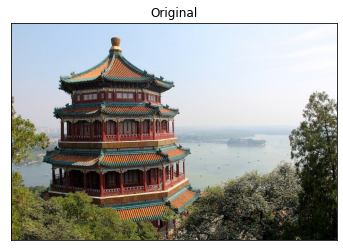

In [1]:
%matplotlib inline
from sklearn.datasets import load_sample_images
from matplotlib import pyplot as plt
import numpy as np

# Display one image
def display_one(img, title1 = "Original", isGray=False):
    if isGray:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)

    plt.title(title1)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
# Display two images
def display_two(original_img, edited_img, title1 = "Original", title2 = "Edited", isGray=False, save_name=""):
    plt.figure(figsize=(18,13))
    
    plt.subplot(121)
    if isGray:
        # If we want to display a gray image, we have to tell pyplot to use a gray color map,
        # otherwise it will not render the image as grayscale
        plt.imshow(original_img, cmap="gray") 
    else:
        plt.imshow(original_img)
    plt.title(title1), plt.xticks([]), plt.yticks([])
    
    plt.subplot(122)
    
    if isGray:
        plt.imshow(edited_img, cmap="gray")
    else:
        plt.imshow(edited_img)
    plt.title(title2), plt.xticks([]), plt.yticks([])

    if save_name:
        plt.tight_layout()
        plt.savefig(save_name)

    plt.show()

dataset = load_sample_images()
original_image = dataset.images[0]
display_one(original_image)

## Image resizing


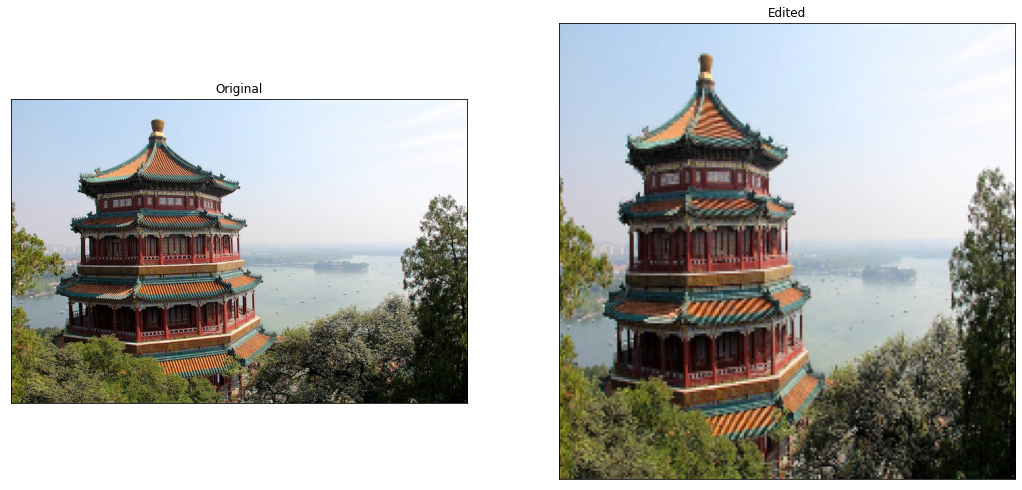

In [2]:
# Resize the image using the cv2.resize() method and linear interpolation
import cv2
height = 220
width = 220
edited_image = cv2.resize(original_image, (height, width))
display_two(original_image, edited_image)

You should have something like this:
![Resized image](./assets/resized_images.jpg)

## Color transformation

Transforming your images into a different color schema is useful. The most common transformation is from color to gray-scale. This is because the detection of objects mostly relies on the shape of an object.
Moreover, because color images contain more information than black and white images, they can add unnecessary complexity and take up more space in memory (Remember how color images are represented in three channels, which means that converting it to gray-scale reduces the number of pixels that need to be processed).

However, as always, it is problem dependent. A machine learning model trained to recognize red rashes on skin surely performs better when it can distinguish the red color from the 'skin-tone' color. In this case, converting the image to gray-scale would be detrimental to the performance of the model.

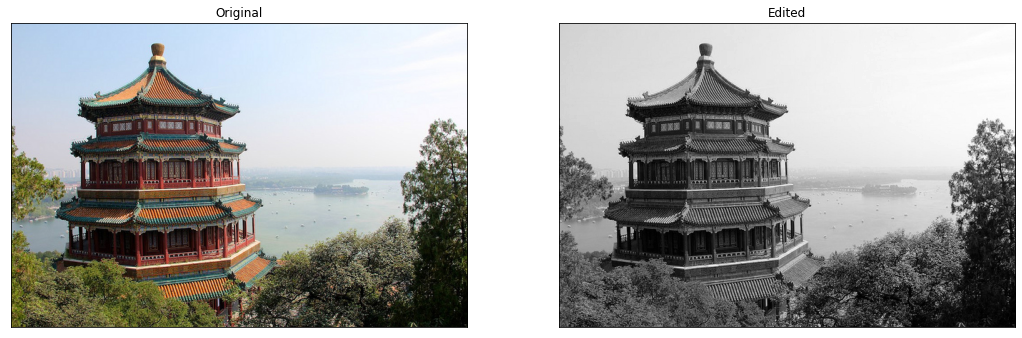

In [3]:
# Transform the image to grayscale using cv2.cvtColor()
edited_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
display_two(original_image, edited_image, isGray=True)

You should have something like this:
![Grayscale image](./assets/grayscale_images.jpg)

## Data augmentation

A common technique to augment the size and the variation of the dataset to give multiple chances to the machine learning model to correctly classify an image are the following transformations, which are depicted in the picture below. 
The most common way of creating more data that is very similar to the original image is to rotate and/or mirror the image. Using this technique, you can get at least twice the amount of data that you had originally.


Depending on the problem, you will want to use some of these or not. These transformations can also be used standalone on an image and feeding only that image to the machine learning model, and not the original image.

* Detexturizing/removing noise
* Color transformation
* Edge enhancement
* Edge detection
* Rotating and mirroring the image   


![Data augmentation (Image)](./assets/data_augmentation.png)

[Image source](https://livebook.manning.com/book/grokking-deep-learning-for-computer-vision/chapter-1/v-8/20)


### Edge enhancement
Edge enhancement can mean a lot of things. In this case, we're using an *unsharp mask* which sharpens the edges of the image, making them stand out more.

In [4]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask.
    
    Taken from https://stackoverflow.com/a/55590133
    """
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

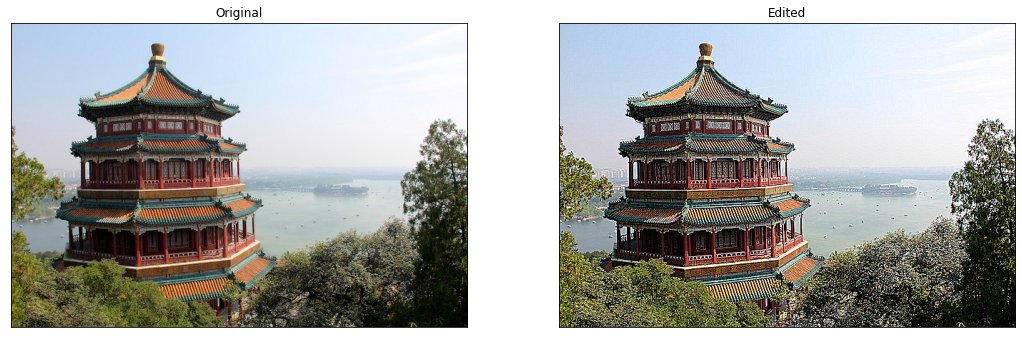

In [5]:
edited_image = unsharp_mask(original_image, amount=3.0)
display_two(original_image, edited_image)

### Rotating and mirroring the image

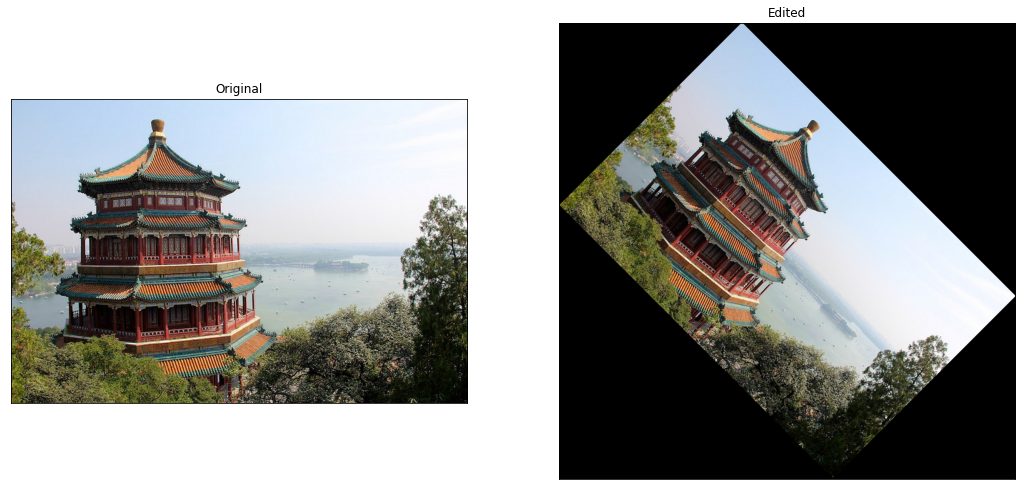

In [6]:
# Rotate the image using scipy.ndimage.rotate()
from scipy import ndimage
edited_image = ndimage.rotate(original_image, -45)
display_two(original_image, edited_image)

You should have something like this:
![Rotated images](./assets/rotated_images.jpg)

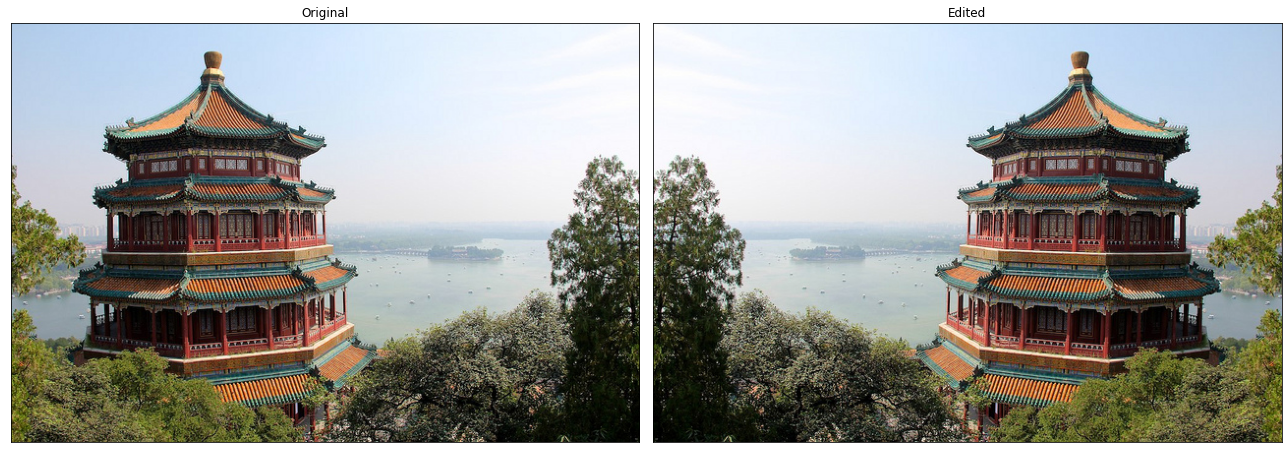

In [7]:
# Mirror the image using cv2.flip()
edited_image = cv2.flip(original_image, flipCode=cv2.ROTATE_180)### FILL IN ###
display_two(original_image, edited_image, save_name="./assets/mirrored_images.jpg")


You can also play around with `flipCode=cv2.ROTATE_90_CLOCKWISE` or `flipCode=cv2.ROTATE_90_COUNTERCLOCKWISE`

You should have something like this for the mirrored image:
![Mirrored images](./assets/mirrored_images.jpg)

## Denoising data

Something, images contain noise that might perturb the machine learning algorithm. Noise in this case are the random changes in brightness and colors in the image. This is often used to remove the false detection of edges in an edge-detection algorithm.
We can smooth out the image to remove most of the noise, which makes the image appear sort of blurry, similar to how it would be seen through a semi-transparent window.


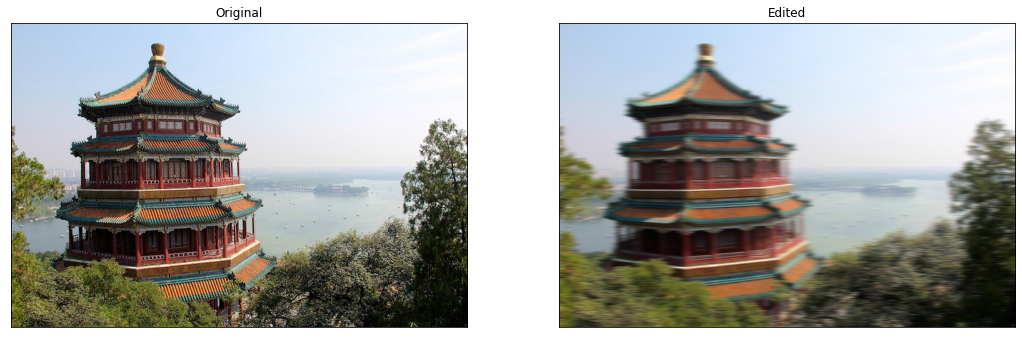

In [8]:
# Remove noise from the picture using cv2.GaussianBlur()
kernel_size=(23, 1) # You can change the kernel size to have more or less smoothing. direction of blurring...(must be odd numbers)
edited_image = cv2.GaussianBlur(original_image, ksize=kernel_size, sigmaX= 0)
# We also should specify the standard deviation in the X and Y directions, sigmaX and sigmaY respectively. 
# If only sigmaX is specified, sigmaY is taken as equal to sigmaX. 
# If both are given as zeros, they are calculated from the kernel size.
display_two(original_image, edited_image)

You should have something like this for the mirrored image:
![Blurred images](./assets/blurred_images.jpg)

## Edge detection

Edge detection - as the name implies - is the task of detecting edges in a picture.
We're using the famous *Canny Edge Detector* to detect edges.

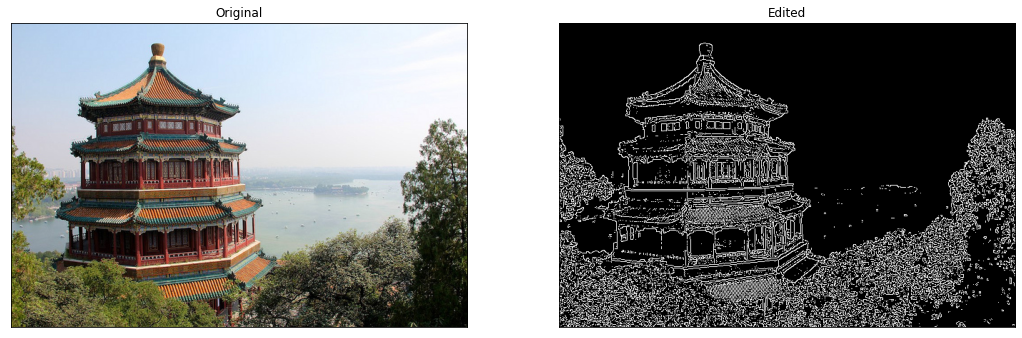

In [15]:
# Detect the edges of an image using cv2.Canny() 

edited_image = cv2.Canny(original_image,200,200)
display_two(original_image, edited_image, isGray=True)

You should have something like this for the mirrored image:
![Image edges](./assets/image_edges.jpg)

## References and more reading material
[Image enhancement - Towards Data Science](https://towardsdatascience.com/image-enhancement-techniques-using-opencv-and-python-9191d5c30d45)

[Image preprocessing pipeline - Medium](https://medium.com/@ManningBooks/the-computer-vision-pipeline-part-3-image-preprocessing-c662094835ec)

[OpenCV Image Processing Tutorial - OpenCV Documentation](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_table_of_contents_imgproc/py_table_of_contents_imgproc.html)